# Diffusion Tensor Imaging

As we saw from the previous notebook, the information captured by dMRI is multi-dimensional. Several techniques have been proposed to summarize different diffusion properties in biological tissues. For instance, diffusion tensor imaging (DTI), a pioneering dMRI technique, was proposed to quantify the anisotropy of diffusion ([Basser et al. 1994](https://pubmed.ncbi.nlm.nih.gov/8130344/)).

Instead of the constant scalar apparent diffusion coefficient, DTI represents diffusion of each image voxel using a second order tensor known as the diffusion tensor:

$$\mathbf{D} = \begin{bmatrix} D_{xx} & D_{xy} & D_{xz} \\ D_{yx} & D_{yy} & D_{yz} \\ D_{zx} & D_{zy} & D_{zz} \end{bmatrix} $$

This tensor can be geometrically represented by an ellipsoid and provides valuable information of tissue diffusion anisotropy. Note that, since diffusion has antipodal symmetry (i.e. diffusion-weighted signal measured along a given direction $\mathbf{n}$ gives the same value than measured by the anti-parallel direction  $\mathbf{-n}$), the across diagonal elements are equal (e.g. $D_{xy}=D_{yx}$). This is why the DTI model involves the estimation of 6 free parameters ($D_{xx}$, $D_{yy}$, $D_{zz}$, $D_{xy}$, $D_{xz}$, $D_{yz}$).

Based on this tensor, DTI models the diffusion-weighted signal by:

$$S ( \mathbf{n}, b) = S_0 exp(-b \mathbf{n}^T \mathbf{D} \mathbf{n})$$ 

In this example we show how to reconstruct dMRI data based on the DTI model. As any other dMRI reconstruction technique, DTI can be called from "dipy.reconst" in the following way:

In [1]:
import dipy.reconst.dti as dti

### Load and read a sample dMRI dataset

For this example, let's load a dMRI dataset that was acquired at the Stanford University.

In [2]:
from dipy.data import get_fnames

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')

Next, we read the downloaded dataset.

In [3]:
from dipy.io.image import load_nifti
from dipy.io.gradients import read_bvals_bvecs

data, affine = load_nifti(hardi_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)

As mentioned on the last tutorial, Dipy use an object called GradientTable to summarizes the diffusion acquisition parameters. Below, we produce this GradientTable object according to the loaded b-values and b-vectors.

In [4]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

Let's print the b-values and b-vectors of this dataset

In [5]:
print("b-value = {} s/mm^2".format(gtab.bvals))
print("b-vectors = {} ".format(gtab.bvecs))

b-value = [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000.] s/mm^2
b-vector

From the information saved in bvals and bvecs, one can note that this dataset was acquired based on a single non-zero b-value along different diffusion gradient direction. This type of single non-zero b-value acquisition are typically refered to as single-shell acquisitions.

### Generate a brain mask

To avoid computation on the background of the image, we generate a brain mask using DIPY's mask module:

In [6]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=range(0, 9),
                             numpass=1, dilate=5)

### DTI reconstruction

Now that we have prepared the datasets we can go forward with the voxel reconstruction. In Dipy voxel reconstruction for all available dMRI techniques consist on two main steps:

1) a given dMRI model is instantiated according to the data acquistion parameters. For the case of DTI, we instantiate the Tensor model in the following way:

In [7]:
dti_model = dti.TensorModel(gtab)

2) after instantiating the model according to the data acquisition parameters, data fitting is very simple - you just need to call the  fit method of the TensorModel in the following way:

In [8]:
dti_fit = dti_model.fit(maskdata)

The fit method creates a TensorFit object which contains the fitting parameters and standard diffusion DTI metrics as object attributes. For instance, the mean diffusivity (MD), axial diffusivity (AD), the radial diffusivity (RD), and Fractional Anisotropy (FA) can be retrieved in the following way:

In [9]:
MD = dti_fit.md
AD = dti_fit.ad
RD = dti_fit.rd
FA = dti_fit.fa

Below we plot the MD, AD, RD and FA maps for an axial slice using matplotlib:

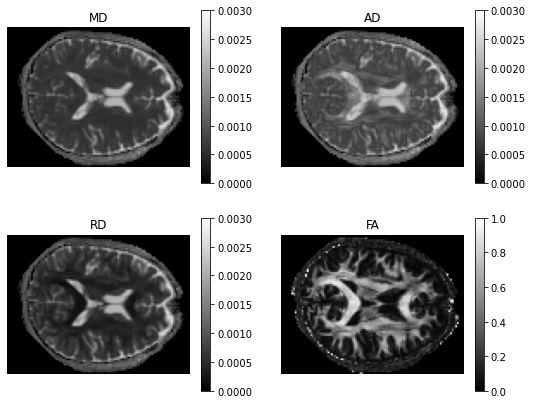

In [10]:
import matplotlib.pyplot as plt

ax_slice = MD.shape[2] // 2;

plt.figure(figsize=(9, 7))

plt.subplot(2, 2, 1).set_axis_off()
plt.imshow(MD[..., ax_slice], cmap='gray', vmin=0, vmax=3e-3)
plt.colorbar()
plt.title("MD")

plt.subplot(2, 2, 2).set_axis_off()
plt.imshow(AD[..., ax_slice], cmap='gray', vmin=0, vmax=3e-3)
plt.colorbar()
plt.title("AD")

plt.subplot(2, 2, 3).set_axis_off()
plt.imshow(RD[..., ax_slice], cmap='gray', vmin=0, vmax=3e-3)
plt.colorbar()
plt.title("RD")

plt.subplot(2, 2, 4).set_axis_off()
plt.imshow(FA[:, :, ax_slice], cmap='gray', vmin=0, vmax=1)
plt.colorbar()
plt.title("FA")

plt.show()

Dipy can also be used to produce a colour coded FA maps. In addition of indicating the anisotropy degree by the colour level intensity, these maps provide the information of the main direction of the diffusion tensor according to the following colour coding standard:

1) red indicates that diffusion is higher on right-left directions

2) green indicates that diffusion is higher on anterior-posterior directions

3) blue indicates that diffusion is higher on inferior-superior directions

The information about the main direction of the diffusion tensor can be retrieved from the diffusion tensor eigenvectors which is saved in "dti_fit" attribute "evecs". The colour coded FA map is produced in the following way:

Text(0.5, 1.0, 'Color coded FA')

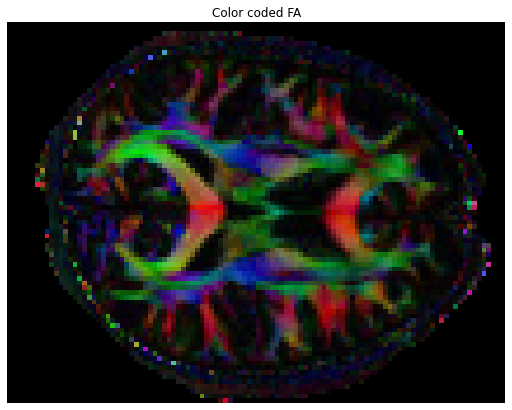

In [11]:
from dipy.reconst.dti import color_fa
import numpy as np

FA = np.clip(FA, 0, 1)  # Just to ensure that FA values are between 0 and 1
colored_FA = color_fa(FA, dti_fit.evecs)

plt.figure(figsize=(9, 7))
plt.subplot(1, 1, 1).set_axis_off()
plt.imshow(colored_FA[:, :, ax_slice])
plt.title("Color coded FA")

### Saving data

Now that you processed the standard DTI metrics, you can saved them as NIFTI files using Dipy's save_nifti function. Here, we choose to save the DTI metrics in float32.

In [12]:
from dipy.io.image import save_nifti
import numpy as np

save_nifti('tensor_md.nii.gz', MD.astype(np.float32), affine)
save_nifti('tensor_ad.nii.gz', AD.astype(np.float32), affine)
save_nifti('tensor_rd.nii.gz', RD.astype(np.float32), affine)
save_nifti('tensor_fa.nii.gz', FA.astype(np.float32), affine)

### Plotting the Ellipsoids (Optional)

If you have fury installed, you can use Dipy to visuallize the DTI's diffusion tensor ellipsoids.

1) For visualization proposes, we will plot the ellipsoids on the following smaller rectangular area of the axial slice. This zoomed area is shown below.

Text(0.5, 1.0, 'Color coded FA')

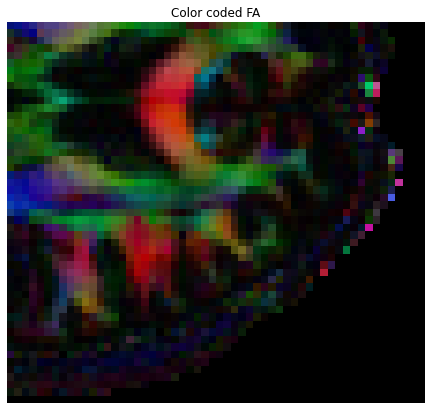

In [13]:
plt.figure(figsize=(9, 7))
plt.subplot(1, 1, 1).set_axis_off()
plt.imshow(colored_FA[30:, 50:, ax_slice])
plt.title("Color coded FA")

2) Below is the code for visuallizing the DTI's diffusion tensor ellipsoids.

In [14]:
from dipy.data import get_sphere
sphere = get_sphere('repulsion724')

from dipy.viz import window, actor

# Enables/disables interactive visualization
interactive = True

scene = window.Scene()

evals = dti_fit.evals[30:, 50:, ax_slice:ax_slice + 1]
evecs = dti_fit.evecs[30:, 50:, ax_slice:ax_slice + 1]

cfa = colored_FA[30:, 50:, ax_slice:ax_slice + 1]
cfa /= cfa.max()

scene.add(actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere,
                              scale=0.7))

print('Saving illustration as tensor_ellipsoids.png')
window.record(scene, n_frames=1, out_path='tensor_ellipsoids.png',
              size=(600, 600))
if interactive:
    window.show(scene)

C:\Users\rafae\anaconda3\envs\dipy_release\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Saving illustration as tensor_ellipsoids.png


### Exercise 1

Below we reload the data that was used for tutorial 001. 

In [15]:
from dipy.data import get_fnames
from dipy.io.image import load_nifti
from dipy.io.gradients import read_bvals_bvecs

fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')
data, affine = load_nifti(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

We also mask the data in two different ways:

In [16]:
from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1)

cropdata, mcrop = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                              numpass=1, autocrop=True)

Note that this time, we mask the data in two different ways:

1) "maskdata" is the masked data with original data field of view

2) "cropdata" is the masked data with cropped field of view, by setting the optional 
"median_otsu" function input "autocrop" to True

We plot the first experiment of the two masked versions of the data

Text(0.5, 1.0, 'Cropped')

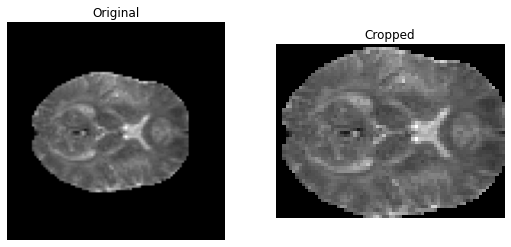

In [17]:
ax_slice = 9

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(maskdata[:, :, ax_slice, 0], cmap='gray')
plt.title("Original")

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(cropdata[:, :, ax_slice, 0], cmap='gray')
plt.title("Cropped")

The objective of the exercise is to compute and plot the standard diffusion tensor metrics (MD, AD, RD, and FA) of the original and cropped version of the data.

In [18]:
# First you need to define the gradient table for the reloaded data
gtab = gradient_table(bvals, bvecs)

# Based on this gradient table we instantiate the Tensor model
tenmodel = dti.TensorModel(gtab)

# We now can fit the two versions of the masked data
tenfit_mask = tenmodel.fit(maskdata)
tenfit_crop = tenmodel.fit(cropdata)

# Retrieving the standard DTI metrics
MD_mask = tenfit_mask.md
AD_mask = tenfit_mask.ad
RD_mask = tenfit_mask.rd
FA_mask = tenfit_mask.fa

MD_crop = tenfit_crop.md
AD_crop = tenfit_crop.ad
RD_crop = tenfit_crop.rd
FA_crop = tenfit_crop.fa

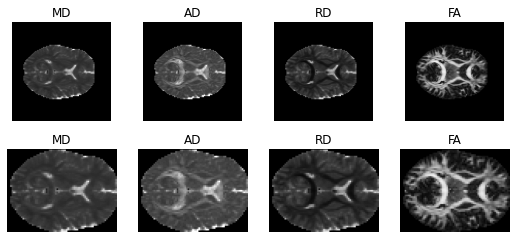

In [19]:
# Plot data
plt.figure(figsize=(9, 4))

plt.subplot(2, 4, 1).set_axis_off()
plt.imshow(MD_mask[..., ax_slice], cmap='gray', vmin=0, vmax=3e-3)
plt.title("MD")

plt.subplot(2, 4, 2).set_axis_off()
plt.imshow(AD_mask[..., ax_slice], cmap='gray', vmin=0, vmax=3e-3)
plt.title("AD")

plt.subplot(2, 4, 3).set_axis_off()
plt.imshow(RD_mask[..., ax_slice], cmap='gray', vmin=0, vmax=3e-3)
plt.title("RD")

plt.subplot(2, 4, 4).set_axis_off()
plt.imshow(FA_mask[..., ax_slice], cmap='gray', vmin=0, vmax=1)
plt.title("FA")

plt.subplot(2, 4, 5).set_axis_off()
plt.imshow(MD_crop[..., ax_slice], cmap='gray', vmin=0, vmax=3e-3)
plt.title("MD")

plt.subplot(2, 4, 6).set_axis_off()
plt.imshow(AD_crop[..., ax_slice], cmap='gray', vmin=0, vmax=3e-3)
plt.title("AD")

plt.subplot(2, 4, 7).set_axis_off()
plt.imshow(RD_crop[..., ax_slice], cmap='gray', vmin=0, vmax=3e-3)
plt.title("RD")

plt.subplot(2, 4, 8).set_axis_off()
plt.imshow(FA_crop[..., ax_slice], cmap='gray', vmin=0, vmax=1)
plt.title("FA")

plt.show()